In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # UserWarning 억제
warnings.filterwarnings("ignore", category=FutureWarning) # FutureWarning 억제

# 심볼 목록 정의
crypto_symbols = ["BTC-USD", "SOL-USD", "XLM-USD", "DOGE-USD", "XRP-USD", "ADA-USD", "SUI20947-USD", "BONK-USD", "LTC-USD", "LINK-USD", "NEAR-USD"]

# 현재 날짜와 시간 가져오기
now = datetime.now()
current_hour = now.replace(minute=0, second=0, microsecond=0)  # 현재 시각의 시 만큼 자르고 더 작은 단위는 0으로 설정

# 데이터 가져오기
crypto_data = yf.download(crypto_symbols, start=current_hour - timedelta(days=30), end=current_hour, interval="1h").fillna(method='ffill')

# Close 가격만 선택
close_prices = crypto_data['Close']

# 오늘 포함된 데이터 확인
print(close_prices.tail())
print(current_hour)

[*********************100%***********************]  11 of 11 completed

Ticker                      ADA-USD  BONK-USD       BTC-USD  DOGE-USD  \
Datetime                                                                
2024-11-18 02:00:00+00:00  0.735961  0.000052  90526.906250  0.372045   
2024-11-18 03:00:00+00:00  0.737559  0.000053  90641.968750  0.371660   
2024-11-18 04:00:00+00:00  0.741834  0.000051  90513.554688  0.372682   
2024-11-18 05:00:00+00:00  0.758318  0.000050  90598.765625  0.368626   
2024-11-18 06:00:00+00:00  0.758033  0.000050  90621.039062  0.368948   

Ticker                      LINK-USD    LTC-USD  NEAR-USD     SOL-USD  \
Datetime                                                                
2024-11-18 02:00:00+00:00  14.286535  90.531029  5.930547  239.802185   
2024-11-18 03:00:00+00:00  14.331145  93.839676  5.995840  243.622971   
2024-11-18 04:00:00+00:00  14.220111  92.508926  5.855438  242.404984   
2024-11-18 05:00:00+00:00  14.402152  93.266098  5.876021  242.249969   
2024-11-18 06:00:00+00:00  14.403140  93.251228  5

In [15]:
# 일반 수익률 계산
returns = crypto_data['Close'].pct_change(fill_method=None).dropna()  # 결측치를 채우지 않음

# 변동성 계산 함수
def calculate_volatility(data, window):
    return data.rolling(window=window).std()

# 각 주기에 대한 변동성 계산
volatility_1h = returns.std() * np.sqrt(1)  # 1시간 변동성
volatility_12h = returns.resample('12h').std().mean() * np.sqrt(12)  # 4시간 변동성
volatility_1D = returns.resample('D').std().mean() * np.sqrt(24)  # 일간 변동성
volatility_3D = returns.resample('3D').std().mean() * np.sqrt(24 * 3)  # 주간 변동성

# 포트폴리오 기대 수익률 (평균으로 설정)
portfolio_return = returns.mean()

# 샤프 지수 계산 (일간 기반)
sharpe_1D = (portfolio_return * 24 - 0) / volatility_1D  # 일간 샤프 비율


# 결과를 데이터프레임으로 정리
volatility_df = pd.DataFrame({
    '1H': (volatility_1h * 100).round(1),
    '12H': (volatility_12h * 100).round(1),
    '1D': (volatility_1D * 100).round(1),
    '3D': (volatility_3D * 100).round(1),
    'Sharpe': sharpe_1D.round(2),
})

# Daily 기준으로 내림차순 정렬
volatility_df_sorted = volatility_df.sort_values(by='1D')

# 결과 출력
print(volatility_df_sorted)

               1H  12H   1D    3D  Sharpe
Ticker                                   
BTC-USD       0.5  1.6  2.3   4.2    0.43
LINK-USD      0.9  2.8  4.0   7.1    0.21
LTC-USD       1.0  2.7  4.0   7.6    0.22
SOL-USD       0.9  2.7  4.0   7.2    0.40
XRP-USD       1.2  3.0  4.5   8.7    0.61
XLM-USD       1.4  3.0  4.7  10.6    0.65
ADA-USD       1.2  3.4  5.0   9.1    0.54
NEAR-USD      1.1  3.6  5.1   9.3    0.15
SUI20947-USD  1.3  4.1  6.1  10.8    0.36
DOGE-USD      1.7  5.0  7.1  12.5    0.48
BONK-USD      1.9  5.3  7.6  13.7    0.38


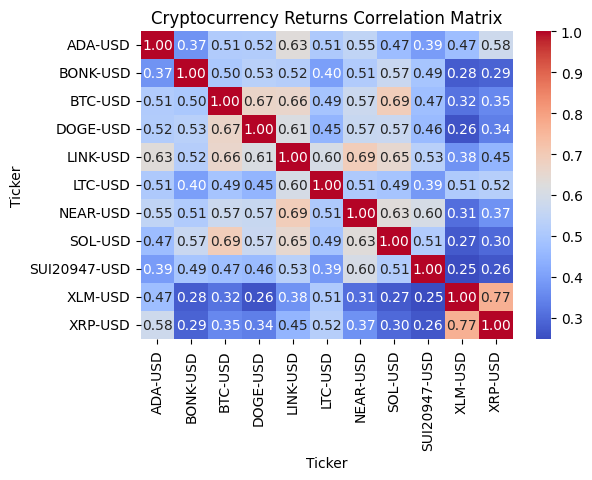

In [16]:
# 상관관계 계산
correlation_matrix = returns.corr()

# 상관관계 시각화
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Cryptocurrency Returns Correlation Matrix')
plt.show()

In [18]:
### 최근 종가 가져오기
recent_close_prices = crypto_data['Close'].iloc[-1]  # 최신 종가

recent_close_prices['BONK-USD'] = recent_close_prices['BONK-USD'] * 1000

# 변동성을 기준으로 가격 계산
Down_prices_1D = recent_close_prices * (1 - (volatility_1D))  # 12시간 변동성 적용
Down_prices_3D = recent_close_prices * (1 - (volatility_3D))  # 일간 변동성 적용
Up_prices_1D = recent_close_prices * (1 + (volatility_1D))  # 일간 변동성 적용
Up_prices_3D = recent_close_prices * (1 + (volatility_3D))  # 일간 변동성 적용


# 결과를 새로운 데이터프레임으로 정리
adjusted_prices_df = pd.DataFrame({
    'Down Price (1D)': Down_prices_1D.round(4),
    'Down Price (3D)': Down_prices_3D.round(4),
    'Up Price (1D)': Up_prices_1D.round(4),
    'Up Price (3D)': Up_prices_3D.round(4)
})
# 결과 출력
print("\nAdjusted Prices DataFrame:")
print(adjusted_prices_df)


Adjusted Prices DataFrame:
              Down Price (1D)  Down Price (3D)  Up Price (1D)  Up Price (3D)
Ticker                                                                      
ADA-USD                0.7198           0.6888         0.7963         0.8272
BONK-USD               0.0463           0.0433         0.0540         0.0570
BTC-USD            88541.8116       86837.0622     92700.2665     94405.0159
DOGE-USD               0.3426           0.3227         0.3953         0.4152
LINK-USD              13.8259          13.3792        14.9804        15.4271
LTC-USD               89.5375          86.1227        96.9650       100.3798
NEAR-USD               5.5688           5.3236         6.1736         6.4188
SOL-USD              232.8060         224.9430       252.2316       260.0947
SUI20947-USD           3.5356           3.3585         3.9922         4.1693
XLM-USD                0.2160           0.2024         0.2371         0.2507
XRP-USD                1.1107           1.0611  

In [23]:
returns = crypto_data['Close'].pct_change().dropna()

# 사용자로부터 비중 입력 받기
weights = pd.Series({
    "BTC-USD": 0.23,
    "SOL-USD": 0.19,
    "XLM-USD": 0.0,
    "DOGE-USD": 0.14,
    "XRP-USD": 0.06,
    "ADA-USD": 0.03,
    "LTC-USD": 0.03,
    "LINK-USD": 0.03,
    "SUI20947-USD":0.03,
    "NEAR-USD":0.03,
    "BONK-USD": 0.03
})

# 공분산 행렬 계산
cov_matrix = returns.cov()

# 포트폴리오 변동성 계산 (일간으로 변환)
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))  # W.T * C * W
portfolio_volatility_hourly = np.sqrt(portfolio_variance)  # 포트폴리오 표준편차 (시간별)
portfolio_volatility_daily = portfolio_volatility_hourly * np.sqrt(24)  # 하루 변동성

# 일간 포트폴리오 기대 수익률 계산
portfolio_mean_hourly = np.dot(weights.T, returns.mean())  # 포트폴리오 시간당 기대 수익률
portfolio_mean_daily = (1 + portfolio_mean_hourly) ** 24 - 1  # 복리 수익률 변환

# 95% 신뢰수준에서의 VaR 계산
z_score = norm.ppf(0.05)  # 95% VaR
var_95_daily = -z_score * portfolio_volatility_daily * 10000  # 포트폴리오 가치 - 손실 금액

# 결과 출력
print(f"Daily Portfolio Volatility: {portfolio_volatility_daily:.2%}")
print(f"Daily Portfolio Mean: {portfolio_mean_daily:.2%}")

Daily Portfolio Volatility: 4.25%
Daily Portfolio Mean: 2.06%


In [27]:
returns = crypto_data['Close'].pct_change().dropna()

# 사용자로부터 각 암호화폐의 수량 입력 받기
quantities = ({
    "BTC-USD": 0.10,
    "SOL-USD": 40,
    "XLM-USD": 00000000,
    "DOGE-USD": 10000,
    "XRP-USD": 2500,
    "ADA-USD": 2000,
    "LINK-USD": 000,
    "SUI20947-USD":00,
    "NEAR-USD":100,
    "LTC-USD": 10,
    "BONK-USD": 30000000,
})

# 현재 가격 가져오기
latest_prices = crypto_data['Close'].iloc[-1]

# 포트폴리오의 각 암호화폐의 현재 가치를 계산
portfolio_value = sum(latest_prices[symbol] * quantities[symbol] for symbol in quantities.keys())

# 포트폴리오 비중 계산
weights = {symbol: (latest_prices[symbol] * quantities[symbol]) / portfolio_value for symbol in quantities.keys()}

# Pandas Series로 변환
weights = pd.Series(weights)

# 공분산 행렬 계산
cov_matrix = returns.cov()

# 포트폴리오 변동성 계산 (일간으로 변환)
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
portfolio_volatility_hourly = np.sqrt(portfolio_variance)
portfolio_volatility_daily = portfolio_volatility_hourly * np.sqrt(24)  # 하루 동안의 변동성

# 일간 포트폴리오 기대 수익률 계산
portfolio_mean_hourly = np.dot(weights.T, returns.mean())
portfolio_mean_daily = (1 + portfolio_mean_hourly) ** 24 - 1  # 복리 수익률 변환

# 95% 신뢰수준에서의 VaR 계산
z_score = norm.ppf(0.05)
var_95_daily = -z_score * portfolio_volatility_daily * portfolio_value  # 포트폴리오 가치

# 결과 출력
print(f"Daily Portfolio Volatility: {portfolio_volatility_daily:.4%}")
print(f"Daily Portfolio Mean: {portfolio_mean_daily:.6%}")
print(f"95% VaR (daily, value): ${var_95_daily:.2f}")

Daily Portfolio Volatility: 5.5401%
Daily Portfolio Mean: 2.619665%
95% VaR (daily, value): $2724.57


In [28]:
# 각 코인별 VaR 계산 및 출력
individual_vars = []  # 각 코인별 VaR를 저장할 리스트

for symbol in crypto_symbols:
    weight = weights[symbol]
    if weight > 0:  # 롱 포지션이 있는 경우에만 VaR 계산
        individual_mean = returns[symbol].mean() * 24  # 일간 기대 수익률
        individual_volatility = returns[symbol].std() * np.sqrt(24)  # 일간 변동성

        individual_var_dollar = weight * (-z_score * individual_volatility * portfolio_value)  # 금액 손실
        individual_var_percent = (individual_var_dollar / portfolio_value) * 100  # 퍼센트 손실

        print(f"{symbol} - 95% VaR (daily, value): ${individual_var_dollar:.2f} ({individual_var_percent:.2f}%)")
        individual_vars.append(individual_var_dollar)  # VaR를 리스트에 추가

# 95% VaR의 총합 계산 및 출력
total_var_95 = sum(individual_vars)
print(f"\nTotal 95% VaR (daily, value): ${total_var_95:.2f}")

BTC-USD - 95% VaR (daily, value): $390.21 (1.31%)
SOL-USD - 95% VaR (daily, value): $674.57 (2.26%)
DOGE-USD - 95% VaR (daily, value): $497.67 (1.66%)
XRP-USD - 95% VaR (daily, value): $291.22 (0.97%)
ADA-USD - 95% VaR (daily, value): $151.86 (0.51%)
BONK-USD - 95% VaR (daily, value): $228.88 (0.77%)
LTC-USD - 95% VaR (daily, value): $73.07 (0.24%)
NEAR-USD - 95% VaR (daily, value): $53.49 (0.18%)

Total 95% VaR (daily, value): $2360.97


In [29]:
# 공분산 행렬 계산
cov_matrix = returns.cov()
mean_returns = returns.mean()

# 코인 그룹 나누기 (예시) - 실제 코인 목록에 맞춰 수정해야 합니다.
first_group = ["BTC-USD", "SOL-USD","XRP-USD"]
second_group = ["XLM-USD", "ADA-USD", "SUI20947-USD", "BONK-USD","DOGE-USD", "LTC-USD"]

# first_group와 second_group에 해당하는 인덱스 얻기
first_indices = [crypto_symbols.index(symbol) for symbol in first_group]
second_indices = [crypto_symbols.index(symbol) for symbol in second_group]


# 최소 변동성과 최대 샤프 비율 최적화 함수 (수정)
def optimize_portfolio(weights):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_volatility
    return -sharpe_ratio # 샤프 비율 최대화를 위해 - 부호를 제거

# 초기 비중 설정
num_assets = len(crypto_symbols)
initial_weights = np.array([1.0 / num_assets] * num_assets)

# 제약 조건 (수정)
constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # 전체 비중 1
    {'type': 'eq', 'fun': lambda weights: np.sum(weights[first_indices]) - 0.8},  # FIRST 그룹 비중 80%
    {'type': 'eq', 'fun': lambda weights: np.sum(weights[second_indices]) - 0.2}  # SECOND 그룹 비중 20%
)
bounds = tuple((0, 1) for asset in range(num_assets))

# 최적화 실행 및 결과 출력 (기존 코드 동일)
optimized_results = minimize(optimize_portfolio, initial_weights, method='trust-constr', bounds=bounds, constraints=constraints, options={'maxiter':1000}) #maxiter 추가


# 최적화된 비중
optimal_weights = optimized_results.x


optimal_return = np.dot(optimal_weights, mean_returns) * 24
optimal_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights))) * np.sqrt(24)
optimal_sharpe = optimal_return / optimal_volatility

print("Optimal Portfolio:")
for i, weight in enumerate(optimal_weights.round(2)):
    print(f"{crypto_symbols[i]}: {weight:.0%}")

print(f"\nExpected Annual Return: {optimal_return:.4%}")
print(f"Annual Volatility: {optimal_volatility:.4%}")
print(f"Sharpe Ratio: {optimal_sharpe:.4f}")

Optimal Portfolio:
BTC-USD: 65%
SOL-USD: 15%
XLM-USD: 0%
DOGE-USD: 15%
XRP-USD: 0%
ADA-USD: 0%
SUI20947-USD: 0%
BONK-USD: 0%
LTC-USD: 5%
LINK-USD: 0%
NEAR-USD: 0%

Expected Annual Return: 2.8297%
Annual Volatility: 5.6489%
Sharpe Ratio: 0.5009
